# Main notebook

## Valerio Fares

## Predicting Startup Success using Crunchbase Data

### Objective
Build an end-to-end data pipeline to analyze and predict startup success 
(acquisition or IPO) based on company characteristics and funding history.

### Dataset
- Crunchbase Companies
- Crunchbase Funding Rounds
- Crunchbase Acquisitions

## Definition of success
A company is considered **successful** if it was:
- Acquired, or
- Went public (IPO)

## Importing libraries

In [539]:
# ENVIRONMENT SETUP

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve




plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Importing data

In [540]:
# DATA LOADING

def load_data(path):
    return pd.read_csv(path, encoding="latin1", low_memory=False)

df_comp = load_data("../data/raw/crunchbase-companies.csv")
df_rnd  = load_data("../data/raw/crunchbase-rounds.csv")
df_acq  = load_data("../data/raw/crunchbase-acquisitions.csv")

print("Companies:", df_comp.shape)
print("Rounds:", df_rnd.shape)
print("Acquisitions:", df_acq.shape)


Companies: (17727, 17)
Rounds: (31679, 13)
Acquisitions: (6185, 20)


In [541]:
df_comp.head(3)

,permalink,name,category_code,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,last_milestone_at
0,/company/waywire,#waywire,news,1750000,operating,USA,NY,New York,New York,1,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,2013-09-06
1,/company/n-plusn,#NAME?,software,600000,operating,USA,NY,New York,New York,1,2012-01-01,2012-01,2012-Q1,2012.0,2012-08-29,2012-08-29,NaN
2,/company/club-domains,.Club Domains,software,7000000,operating,USA,FL,Fort Lauderdale,Oakland Park,1,2011-10-10,2011-10,2011-Q4,2011.0,2013-05-31,2013-05-31,NaN


In [542]:
df_rnd.head(3)

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/waywire,#waywire,news,USA,NY,New York,New York,series-a,2012-06-30,2012-06,2012-Q2,2012,1750000.0
1,/company/n-plusn,#NAME?,software,USA,NY,New York,New York,angel,2012-08-29,2012-08,2012-Q3,2012,600000.0
2,/company/club-domains,.Club Domains,software,USA,FL,Fort Lauderdale,Oakland Park,series-b,2013-05-31,2013-05,2013-Q2,2013,7000000.0


In [543]:
df_acq.head(3)

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,acquirer_category_code,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,/company/1000memories,1000memories,web,USA,CA,SF Bay,San Francisco,/company/ancestry-com,Ancestry,ecommerce,USA,UT,Salt Lake City,Provo,2012-10-03,2012-10,2012-Q4,2012.0,NaN,USD
1,/company/100plus,100Plus,analytics,USA,CA,SF Bay,San Francisco,/company/practice-fusion,Practice Fusion,health,USA,CA,SF Bay,San Francisco,2013-02-27,2013-02,2013-Q1,2013.0,NaN,USD
2,/company/10best,10best,web,USA,SC,Greenville,Greenville,/company/nile-guide,NileGuide,travel,USA,CA,SF Bay,San Francisco,2011-01-25,2011-01,2011-Q1,2011.0,NaN,USD


In [544]:
# NORMALIZE PERMALINKS FORMAT TO BE USED AS JOIN KEY
for df in [df_comp, df_rnd, df_acq]:
    col = "permalink" if "permalink" in df.columns else "company_permalink"
    df[col] = df[col].astype(str).str.lower().str.strip()
    if col != "company_permalink":
        df.rename(columns={col: "company_permalink"}, inplace=True)

# Remove malformed permalinks
df_comp = df_comp[df_comp["company_permalink"].str.contains("/company/")]

We use `company_permalink` as a unique identifier across all datasets.
Malformed or missing permalinks are removed to ensure consistent joins.

### Additional features

In [545]:
# FUNDING AGGREGATION

df_rnd["funded_at"] = pd.to_datetime(df_rnd["funded_at"], errors="coerce")

funding_metrics = df_rnd.groupby("company_permalink").agg(
    total_funding_usd = ("raised_amount_usd", "sum"),
    avg_round_amount  = ("raised_amount_usd", "mean"),
    max_round_amount  = ("raised_amount_usd", "max"),
    num_funding_rounds = ("company_permalink", "count"),
    first_funding_date = ("funded_at", "min"),
    last_funding_date  = ("funded_at", "max")
).reset_index()

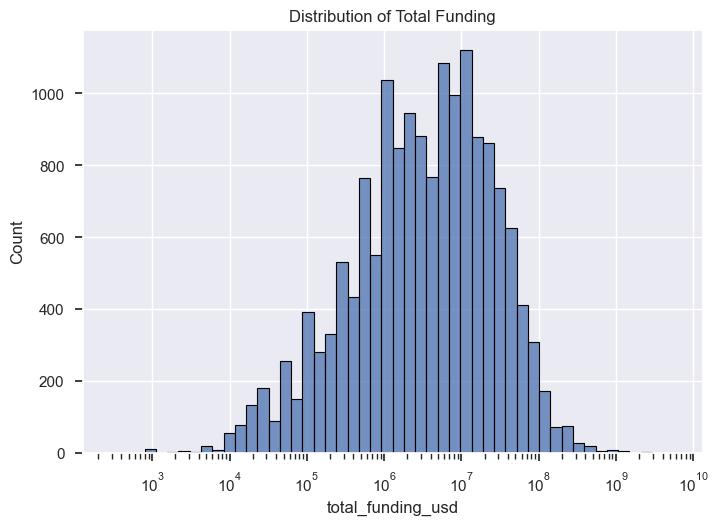

In [546]:
sns.histplot(
    funding_metrics["total_funding_usd"].dropna(),
    log_scale=True,
    bins=50
)
plt.title("Distribution of Total Funding")
plt.show()

In [547]:
# FUNDING ROUND TYPE FLAGS

round_flags = pd.get_dummies(
    df_rnd.set_index("company_permalink")["funding_round_type"],
    prefix="has"
)
round_flags = round_flags.groupby(level=0).max().reset_index()

Funding structure (angel, series A/B/C, venture) captures company maturity 
and investor confidence beyond raw funding amounts.

In [548]:
# ACQUISITION & STATUS FLAGS

acquired_set = set(df_acq["company_permalink"].unique())

df_final = (
    df_comp
    .merge(funding_metrics, on="company_permalink", how="left")
    .merge(round_flags, on="company_permalink", how="left")
)

flag_cols = [c for c in df_final.columns if c.startswith("has_")]

df_final[flag_cols] = df_final[flag_cols].fillna(0).astype(int)
df_final["total_funding_usd"] = df_final["total_funding_usd"].fillna(0)
df_final["num_funding_rounds"] = df_final["num_funding_rounds"].fillna(0)

df_final["is_acquired"]  = df_final["company_permalink"].isin(acquired_set).astype(int)
df_final["is_ipo"]       = df_final["status"].eq("ipo").astype(int)
df_final["is_closed"]    = df_final["status"].eq("closed").astype(int)
df_final["is_operating"] = df_final["status"].eq("operating").astype(int)

In [549]:
df_final[["is_acquired","is_ipo","is_closed","is_operating"]].mean()

is_acquired     0.094150
is_ipo          0.019405
is_closed       0.031195
is_operating    0.855023
dtype: float64

In [550]:
# TEMPORAL FEATURES

df_final["founded_at"] = pd.to_datetime(df_final["founded_at"], errors="coerce")

SNAPSHOT_DATE = pd.to_datetime("2013-12-31")

df_final["company_age_years"] = (
    (SNAPSHOT_DATE - df_final["founded_at"]).dt.days / 365.25
)

df_final["years_to_first_funding"] = (
    (df_final["first_funding_date"] - df_final["founded_at"]).dt.days / 365.25
)

df_final.loc[df_final["company_age_years"] < 0, "company_age_years"] = np.nan

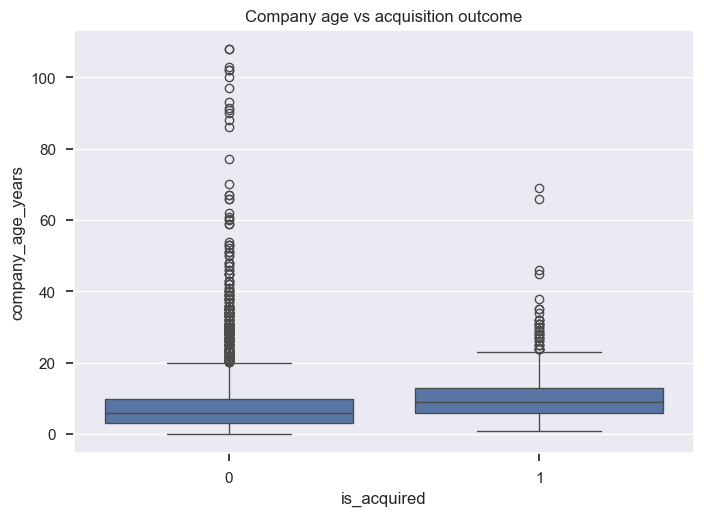

In [551]:
sns.boxplot(
    data=df_final,
    x="is_acquired",
    y="company_age_years"
)
plt.title("Company age vs acquisition outcome")
plt.show()

## Data preprocessing and descriptive analysis

In [552]:
print("Initial shape:", df_final.shape)

missing_ratio = (
    df_final.isna()
    .mean()
    .sort_values(ascending=False)
)

missing_ratio.head(15)

Initial shape: (17727, 38)


last_milestone_at         0.406104
years_to_first_funding    0.233542
founded_at                0.228521
company_age_years         0.228521
founded_year              0.228521
founded_quarter           0.228521
founded_month             0.228521
avg_round_amount          0.087212
max_round_amount          0.087212
funding_total_usd         0.084899
category_code             0.022508
city                      0.014949
state_code                0.013934
first_funding_at          0.005923
last_funding_at           0.005923
dtype: float64

Dropping all rows with missing values would remove a large fraction of the dataset.
Instead, we:
- Drop only columns with high missingness and low predictive value
- Derive useful features from temporal columns
- Impute missing values using semantically meaningful defaults

In [553]:
# ROP NON INFORMATIVE COLUMNS

cols_to_drop = [
    "last_milestone_at",   # >40% missing
    "founded_at",
    "founded_month",
    "founded_quarter"
]

df = df_final.drop(columns=cols_to_drop, errors="ignore")

print("Shape after dropping columns:", df.shape)

Shape after dropping columns: (17727, 34)


Milestone and raw date columns are removed after feature derivation to:
- reduce redundancy
- control missingness
- avoid high cardinality noise

In [554]:
# CATEGORICAL CARDINALITY
cat_cols = ["category_code", "state_code", "region", "city"]

for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

category_code: 42 unique values
state_code: 51 unique values
region: 794 unique values
city: 1960 unique values


Categorical variables are informative but sparse.
Missing values are filled with explicit categories instead of dropping rows.

In [555]:
# Fill non critical categorical NaNs
df["category_code"] = df["category_code"].fillna("not_defined")
df["state_code"]    = df["state_code"].fillna("not_defined")
df["city"]          = df["city"].fillna("other")
df["region"]        = df["region"].fillna("other")

In [556]:
# DROP ROWS WITH CRITICAL NUMERIC NaNs

critical_numeric = [
    "funding_total_usd",
    "founded_year"
]

before = df.shape[0]

df = df[df["funding_total_usd"].notna()]
df = df[df["founded_year"].notna()]

after = df.shape[0]

print(f"Rows dropped: {before - after}")
print("Remaining rows:", after)

# numeric imputation
df["avg_round_amount"] = df["avg_round_amount"].fillna(0)
df["max_round_amount"] = df["max_round_amount"].fillna(0)
df["years_to_first_funding"] = df["years_to_first_funding"].fillna(-1) # -1 for never funded

Rows dropped: 5181
Remaining rows: 12546


Only rows missing critical numeric features are removed.
This preserves the majority of observations while maintaining feature integrity.

In [557]:
# TOP-20 GROUPING FOR SPARSITY CONTROL

TOP_K = 20

top_regions = df["region"].value_counts().nlargest(TOP_K).index
top_cities  = df["city"].value_counts().nlargest(TOP_K).index

df["region_grouped"] = df["region"].apply(
    lambda x: x if x in top_regions else "other"
)

df["city_grouped"] = df["city"].apply(
    lambda x: x if x in top_cities else "other"
)

# Drop original high-cardinality columns
df = df.drop(columns=["region", "city", "country_code"], errors="ignore")

Top-20 grouping controls sparsity while preserving the most informative geographic regions.

In [558]:
# BINARY ENCODING HELPER

def make_binary_flags(df, column, top_k=20):
    """
    Converts a categorical column into binary indicator variables.
    Keeps top_20 categories and groups the rest as 'other'.
    """
    top_values = df[column].value_counts().nlargest(top_k).index.tolist()

    df[f"{column}_bucket"] = df[column].apply(
        lambda x: x if x in top_values else "other"
    )

    dummies = pd.get_dummies(
        df[f"{column}_bucket"],
        prefix=f"has_{column}"
    )

    df = pd.concat([df, dummies], axis=1)
    df = df.drop(columns=[column, f"{column}_bucket"], errors="ignore")

    return df

cols_to_transform = [
    "category_code",
    "state_code",
    "region_grouped",
    "city_grouped"
]

for col in cols_to_transform:
    df = make_binary_flags(df, col, top_k=20)


for col in ["first_funding_at", "last_funding_at"]:
    df[col] = pd.to_datetime(df[col], errors="coerce").dt.year

df = df.drop(columns=["first_funding_date"], errors="ignore")

print("Final shape after encoding:", df.shape)

numeric_cols = [
    "funding_total_usd",
    "avg_round_amount",
    "max_round_amount",
    "num_funding_rounds",
    "company_age_years",
    "years_to_first_funding"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Convert binary flags to int
for col in df.columns:
    if col.startswith("has_"):
        df[col] = df[col].astype(int)


numeric_cols = [
    "funding_total_usd",
    "avg_round_amount",
    "max_round_amount",
    "num_funding_rounds",
    "company_age_years",
    "years_to_first_funding"
]

# Ensure numeric types
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Final NaN handling
df[numeric_cols] = df[numeric_cols].fillna(0)

Final shape after encoding: (12546, 109)


In [559]:
df.describe(include="all").transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
company_permalink,12546,12546,/company/waywire,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,12546,12546,#waywire,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funding_total_usd,12546.0,NaN,NaN,NaN,17871883.925713,0.0,725000.0,3709171.0,15000000.0,5700000000.0,79220588.591137
status,12546,4,operating,10660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funding_rounds,12546.0,NaN,NaN,NaN,1.955045,1.0,1.0,1.0,2.0,14.0,1.381673
...,...,...,...,...,...,...,...,...,...,...,...
has_city_grouped_Santa Clara,12546.0,NaN,NaN,NaN,0.014746,0.0,0.0,0.0,0.0,1.0,0.120538
has_city_grouped_Santa Monica,12546.0,NaN,NaN,NaN,0.008847,0.0,0.0,0.0,0.0,1.0,0.093648
has_city_grouped_Seattle,12546.0,NaN,NaN,NaN,0.022956,0.0,0.0,0.0,0.0,1.0,0.149768
has_city_grouped_Sunnyvale,12546.0,NaN,NaN,NaN,0.015144,0.0,0.0,0.0,0.0,1.0,0.122132


After cleaning:
- Missing values are handled without excessive data loss
- High cardinality categoricals are controlled
- All features are numeric and ready for modeling
- Dataset is stable for exploratory analysis, clustering and modeling

## Exploratory Analysis & Structure Discovery

In [560]:
print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (12546, 109)


,company_permalink,name,funding_total_usd,status,funding_rounds,founded_year,first_funding_at,last_funding_at,total_funding_usd,avg_round_amount,...,has_city_grouped_Redwood City,has_city_grouped_San Diego,has_city_grouped_San Francisco,has_city_grouped_San Jose,has_city_grouped_San Mateo,has_city_grouped_Santa Clara,has_city_grouped_Santa Monica,has_city_grouped_Seattle,has_city_grouped_Sunnyvale,has_city_grouped_other
0,/company/waywire,#waywire,1750000.0,operating,1,2012.0,2012.0,2012.0,1750000.0,1750000.0,...,0,0,0,0,0,0,0,0,0,0
1,/company/n-plusn,#NAME?,600000.0,operating,1,2012.0,2012.0,2012.0,600000.0,600000.0,...,0,0,0,0,0,0,0,0,0,0
2,/company/club-domains,.Club Domains,7000000.0,operating,1,2011.0,2013.0,2013.0,7000000.0,7000000.0,...,0,0,0,0,0,0,0,0,0,1
5,/company/10-20-media,10-20 Media,750000.0,operating,2,2001.0,2010.0,2011.0,750000.0,375000.0,...,0,0,0,0,0,0,0,0,0,1
6,/company/1000memories,1000memories,2535000.0,acquired,2,2010.0,2010.0,2011.0,2535000.0,1267500.0,...,0,0,1,0,0,0,0,0,0,0


At this stage, the dataset contains only cleaned and engineered features.
No target variable is used to avoid bias in exploratory analysis.

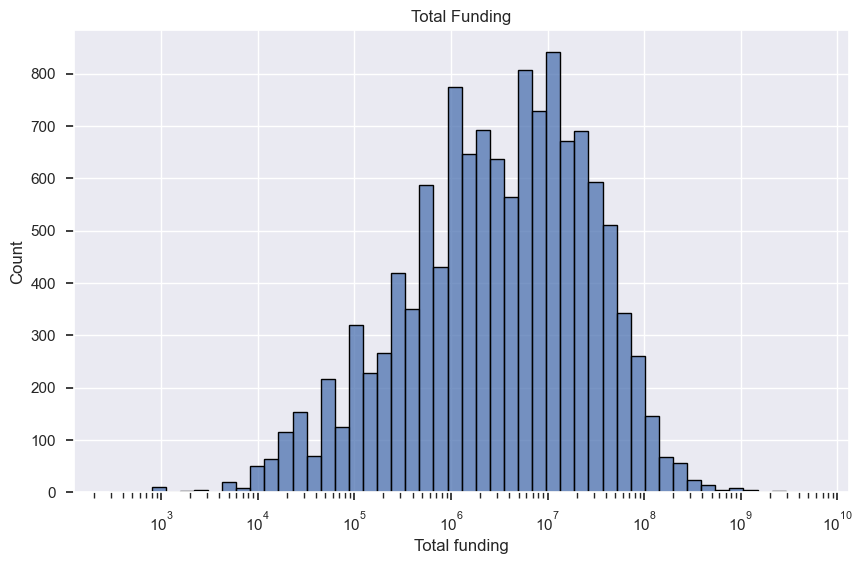

In [561]:
plt.figure(figsize=(10,6))
sns.histplot(
    df["funding_total_usd"],
    bins=50,
    log_scale=True
)
plt.title("Total Funding")
plt.xlabel("Total funding")
plt.ylabel("Count")
plt.show()

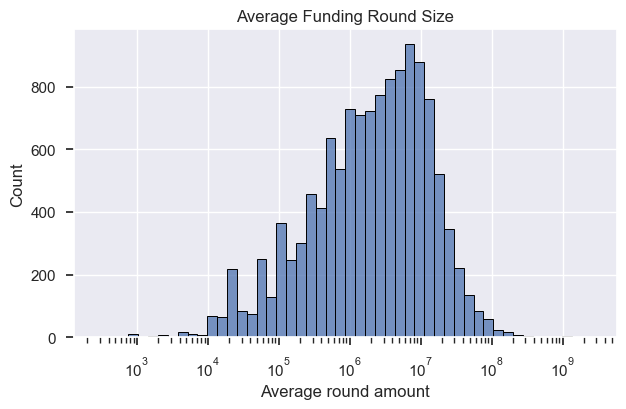

In [562]:
plt.figure(figsize=(7,4))
sns.histplot(
    df["avg_round_amount"],
    bins=50,
    log_scale=True
)
plt.title("Average Funding Round Size")
plt.xlabel("Average round amount")
plt.ylabel("Count")
plt.show()

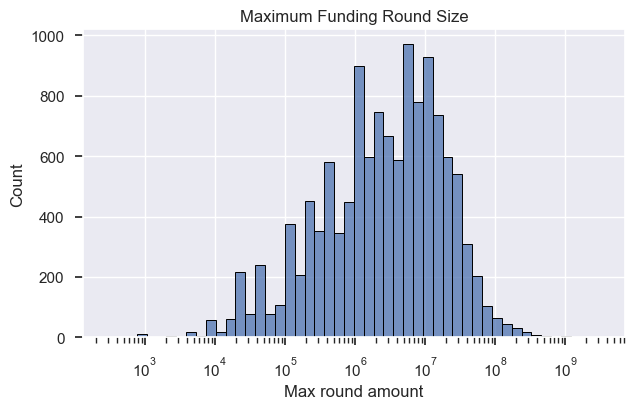

<Axes: xlabel='num_funding_rounds', ylabel='Count'>

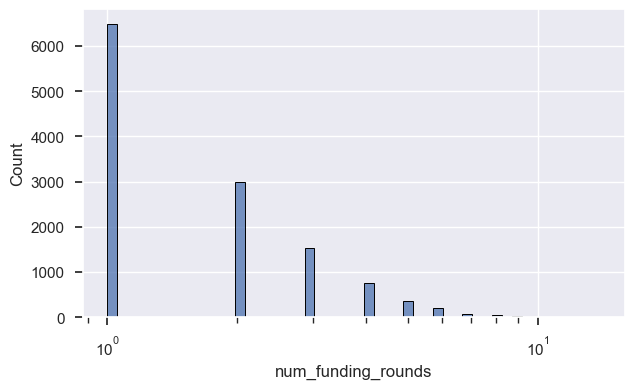

In [563]:
plt.figure(figsize=(7,4))
sns.histplot(
    df["max_round_amount"],
    bins=50,
    log_scale=True
)
plt.title("Maximum Funding Round Size")
plt.xlabel("Max round amount")
plt.ylabel("Count")
plt.show()
plt.figure(figsize=(7,4))
sns.histplot(
    df["num_funding_rounds"],
    bins=50,
    log_scale=True
)

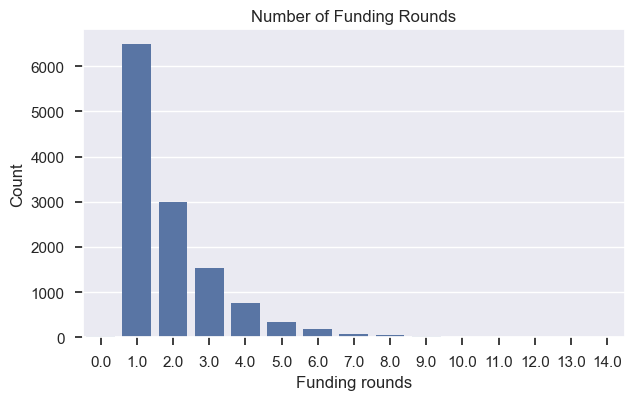

In [564]:
# Number of funding rounds

plt.figure(figsize=(7,4))
sns.countplot(
    x="num_funding_rounds",
    data=df
)
plt.title("Number of Funding Rounds")
plt.xlabel("Funding rounds")
plt.ylabel("Count")
plt.show()

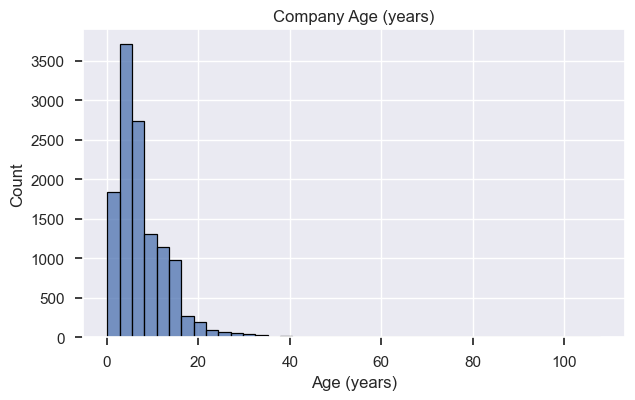

In [565]:
plt.figure(figsize=(7,4))
sns.histplot(
    df["company_age_years"],
    bins=40
)
plt.title("Company Age (years)")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()

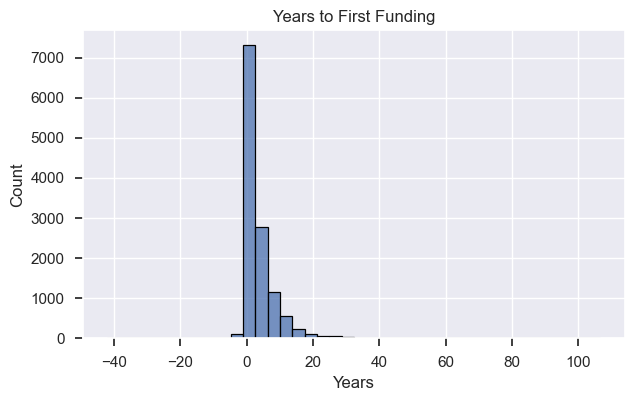

In [566]:
plt.figure(figsize=(7,4))
sns.histplot(
    df["years_to_first_funding"],
    bins=40
)
plt.title("Years to First Funding")
plt.xlabel("Years")
plt.ylabel("Count")
plt.show()

Most startups raise funding within the first few years.
Negative values correspond to companies with no recorded funding events.

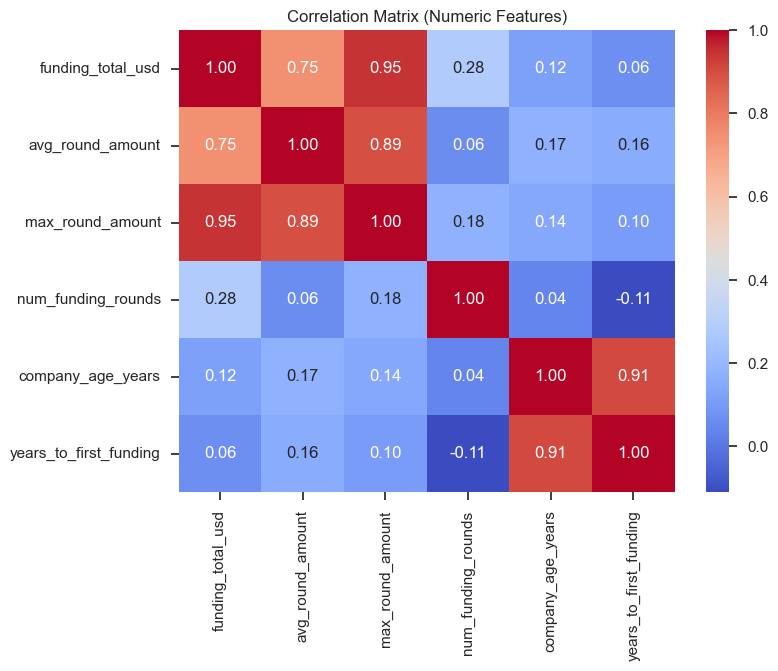

In [567]:
# CORRELATION MATRIX

numeric_cols = [
    "funding_total_usd",
    "avg_round_amount",
    "max_round_amount",
    "num_funding_rounds",
    "company_age_years",
    "years_to_first_funding"
]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

In [568]:
# Feature scaling (for structure discovery)

numeric_cols = [
    "funding_total_usd",
    "avg_round_amount",
    "max_round_amount",
    "num_funding_rounds",
    "company_age_years",
    "years_to_first_funding"
]

X = df[numeric_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

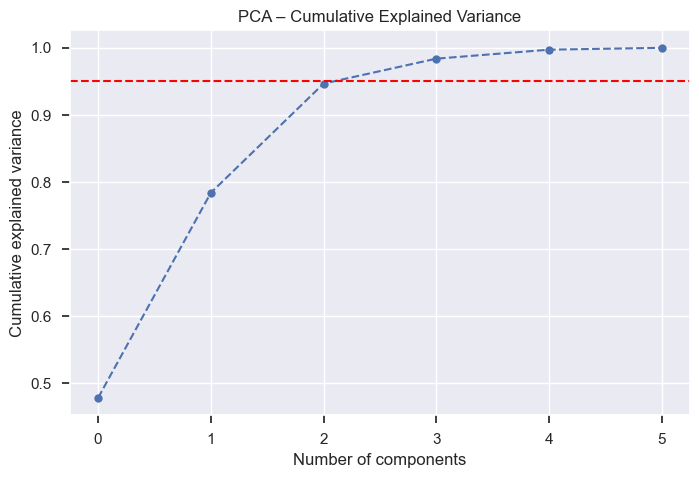

In [569]:
# PCA — Exploratory dimensionality reduction

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.plot(
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
    linestyle="--"
)
plt.axhline(0.95, color="red", linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Cumulative Explained Variance")
plt.show()

A relatively small number of components explains most of the variance,
indicating strong feature redundancy.

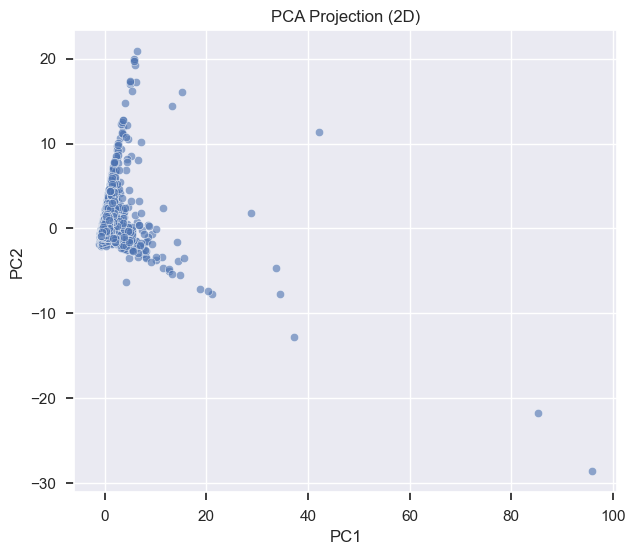

In [570]:
# PCA 2D PROJECTION

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca_2d[:,0],
    y=X_pca_2d[:,1],
    alpha=0.6
)
plt.title("PCA Projection (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

The PCA projection shows a continuous structure rather than
clearly separable groups.

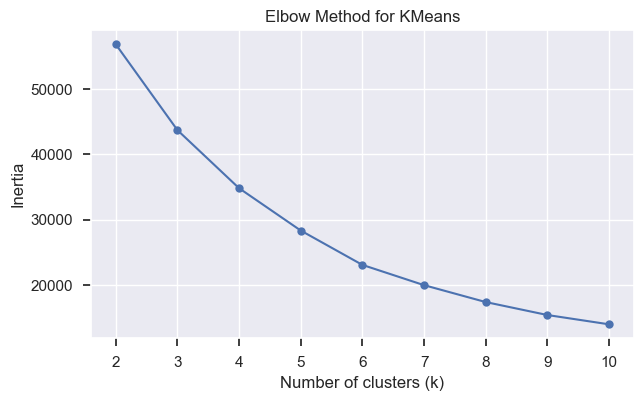

In [571]:
# ELBOW METHOD

inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init=10
    )
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()

The elbow suggests a small number of dominant clusters (k=4),
indicating a limited set of startup archetypes.

In [572]:
# KMEANS CLUSTERING

kmeans = KMeans(
    n_clusters=4,
    random_state=RANDOM_STATE,
    n_init=10
)

clusters = kmeans.fit_predict(X_scaled)

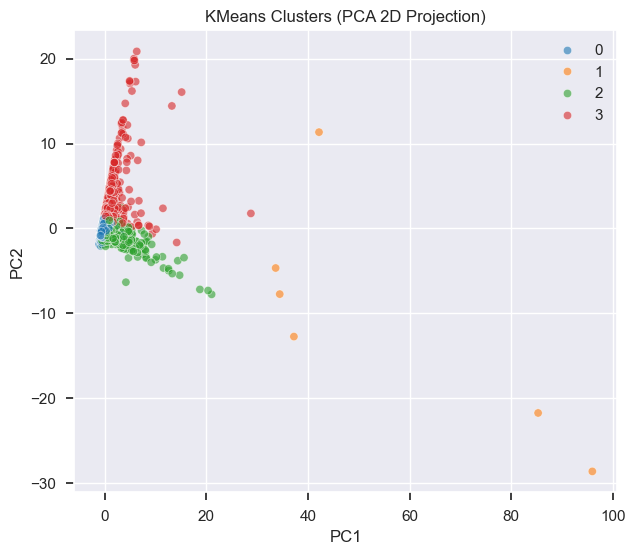

In [573]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca_2d[:,0],
    y=X_pca_2d[:,1],
    hue=clusters,
    palette="tab10",
    alpha=0.6
)
plt.title("KMeans Clusters (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [574]:
# CLUSTER PROFILES

df_clustered = df.copy()
df_clustered["cluster"] = clusters

cluster_profile = (
    df_clustered
    .groupby("cluster")[numeric_cols]
    .mean()
)

cluster_profile

,funding_total_usd,avg_round_amount,max_round_amount,num_funding_rounds,company_age_years,years_to_first_funding
cluster,,,,,,
0,6.129676e+06,4.243079e+06,4.959579e+06,1.484600,5.778882,2.315138
1,2.312617e+09,1.232586e+09,1.741667e+09,3.166667,29.626740,25.224276
2,6.140734e+07,1.567009e+07,3.066348e+07,4.363592,8.896894,2.688220
3,2.218951e+07,1.713242e+07,1.905949e+07,1.377853,21.616561,17.566883


Clusters differ mainly in funding intensity, number of rounds
and company maturity, revealing distinct startup profiles.

Unsupervised clustering revealed a small cluster of extreme outliers
characterized by very high funding amounts and unusually long company lifespans.

These observations correspond to legacy or atypical firms that are not
representative of the startup dynamics studied in this project.

To improve stability and generalization of supervised models,
this cluster is excluded from downstream modeling.

In [575]:
# EXCLUDE STRUCTURAL OUTLIERS

df_clustered = df.copy()
df_clustered["cluster"] = clusters

df_clustered["cluster"].value_counts()

cluster
0    9286
2    2071
3    1183
1       6
Name: count, dtype: int64

In [576]:
df_model_base = df_clustered[df_clustered["cluster"] != 1].copy()

print("Shape before exclusion:", df.shape)
print("Shape after exclusion:", df_model_base.shape)

df_model_base = df_model_base.drop(columns=["cluster"])

Shape before exclusion: (12546, 109)
Shape after exclusion: (12540, 110)


## Modeling

A company is considered successful if it was acquired or went public (IPO).
This definition is introduced only at the modeling stage to avoid bias
in exploratory and unsupervised analyses.

In [577]:
# TARGET DEFINITION

df_model = df_model_base.copy()

df_model["success"] = (
    (df_model["is_acquired"] == 1) |
    (df_model["is_ipo"] == 1)
).astype(int)

df_model["success"].value_counts(normalize=True)

success
0    0.881898
1    0.118102
Name: proportion, dtype: float64

Identifier and status columns are removed.
Only engineered numeric and binary features are retained.

In [578]:
# FEATURE SELECTION

drop_cols = [
    # target-related
    "success",
    "is_acquired",
    "is_ipo",
    "is_closed",
    "is_operating",
    "last_funding_date",

    # identifiers / text
    "company_permalink",
    "name",
    "status"
]

X = df_model.drop(columns=drop_cols, errors="ignore")
y = df_model["success"]

X[["first_funding_at", "last_funding_at"]] = (
    X[["first_funding_at", "last_funding_at"]].fillna(0)
)

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts())

X.head()

X shape: (12540, 101)
y distribution:
success
0    11059
1     1481
Name: count, dtype: int64


,funding_total_usd,funding_rounds,founded_year,first_funding_at,last_funding_at,total_funding_usd,avg_round_amount,max_round_amount,num_funding_rounds,has_angel,...,has_city_grouped_Redwood City,has_city_grouped_San Diego,has_city_grouped_San Francisco,has_city_grouped_San Jose,has_city_grouped_San Mateo,has_city_grouped_Santa Clara,has_city_grouped_Santa Monica,has_city_grouped_Seattle,has_city_grouped_Sunnyvale,has_city_grouped_other
0,1750000.0,1,2012.0,2012.0,2012.0,1750000.0,1750000.0,1750000.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
1,600000.0,1,2012.0,2012.0,2012.0,600000.0,600000.0,600000.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2,7000000.0,1,2011.0,2013.0,2013.0,7000000.0,7000000.0,7000000.0,1.0,0,...,0,0,0,0,0,0,0,0,0,1
5,750000.0,2,2001.0,2010.0,2011.0,750000.0,375000.0,500000.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
6,2535000.0,2,2010.0,2010.0,2011.0,2535000.0,1267500.0,2520000.0,2.0,1,...,0,0,1,0,0,0,0,0,0,0


In [579]:
# TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

y_train.value_counts(normalize=True)

success
0    0.881878
1    0.118122
Name: proportion, dtype: float64

Baseline models are trained on the original feature space
to establish reference performance.

In [580]:
# SCALING (NO PCA)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [581]:
def evaluate_model_auc(model, X_test, y_test, name):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    auc = roc_auc_score(y_test, y_proba)

    print("\n" + "="*60)
    print(f"{name}")
    print("="*60)
    print(f"ROC-AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return auc, y_proba

In [582]:
lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

lr.fit(X_train_scaled, y_train)
lr_auc, lr_proba = evaluate_model_auc(
    lr, X_test_scaled, y_test, "Logistic Regression"
)


Logistic Regression
ROC-AUC: 0.7879

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2212
           1       0.26      0.73      0.38       296

    accuracy                           0.72      2508
   macro avg       0.60      0.72      0.60      2508
weighted avg       0.87      0.72      0.77      2508



In [583]:
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_auc, rf_proba = evaluate_model_auc(
    rf, X_test, y_test, "Random Forest"
)


Random Forest
ROC-AUC: 0.8192

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2212
           1       0.41      0.06      0.11       296

    accuracy                           0.88      2508
   macro avg       0.65      0.53      0.52      2508
weighted avg       0.83      0.88      0.84      2508



In [584]:
xgb = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight = (len(y_train[y_train==0]) / len(y_train[y_train==1])),
    learning_rate=0.05,
    max_depth=6,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_auc, xgb_proba = evaluate_model_auc(
    xgb, X_test, y_test, "XGBoost"
)


XGBoost
ROC-AUC: 0.8167

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      2212
           1       0.33      0.62      0.43       296

    accuracy                           0.80      2508
   macro avg       0.63      0.73      0.66      2508
weighted avg       0.87      0.80      0.83      2508



In [585]:
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance"
)

knn.fit(X_train_scaled, y_train)
knn_auc, knn_proba = evaluate_model_auc(
    knn, X_test_scaled, y_test, "KNN"
)


KNN
ROC-AUC: 0.6389

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      2212
           1       0.20      0.05      0.09       296

    accuracy                           0.86      2508
   macro avg       0.54      0.51      0.51      2508
weighted avg       0.80      0.86      0.83      2508



In [586]:
nb = GaussianNB()

nb.fit(X_train_scaled, y_train)
nb_auc, nb_proba = evaluate_model_auc(
    nb, X_test_scaled, y_test, "Naive Bayes"
)


Naive Bayes
ROC-AUC: 0.6504

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.40      0.56      2212
           1       0.15      0.79      0.25       296

    accuracy                           0.44      2508
   macro avg       0.54      0.59      0.40      2508
weighted avg       0.84      0.44      0.52      2508



In [587]:
svm = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    class_weight="balanced",
    random_state=42
)

svm.fit(X_train_scaled, y_train)
svm_auc, svm_proba = evaluate_model_auc(
    svm, X_test_scaled, y_test, "SVM (RBF)"
)


SVM (RBF)
ROC-AUC: 0.7524

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      2212
           1       0.23      0.63      0.34       296

    accuracy                           0.71      2508
   macro avg       0.58      0.68      0.58      2508
weighted avg       0.85      0.71      0.76      2508



In [588]:
results_auc = pd.Series({
    "Logistic Regression": lr_auc,
    "Random Forest": rf_auc,
    "XGBoost": xgb_auc,
    "KNN": knn_auc,
    "Naive Bayes": nb_auc,
    "SVM": svm_auc
}).sort_values(ascending=False)

results_auc

Random Forest          0.819225
XGBoost                0.816726
Logistic Regression    0.787915
SVM                    0.752380
Naive Bayes            0.650402
KNN                    0.638931
dtype: float64

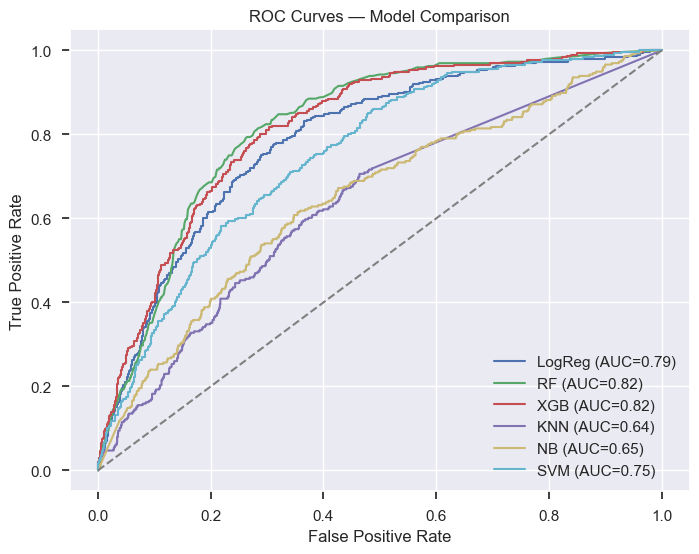

In [589]:
plt.figure(figsize=(8,6))

models_roc = {
    "LogReg": lr_proba,
    "RF": rf_proba,
    "XGB": xgb_proba,
    "KNN": knn_proba,
    "NB": nb_proba,
    "SVM": svm_proba
}

for name, proba in models_roc.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Model Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [590]:
# PCA — retain 95% variance
pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original shape:", X_train_scaled.shape)
print("PCA shape:", X_train_pca.shape)
print("Components selected:", pca.n_components_)

Original shape: (10032, 101)
PCA shape: (10032, 65)
Components selected: 65


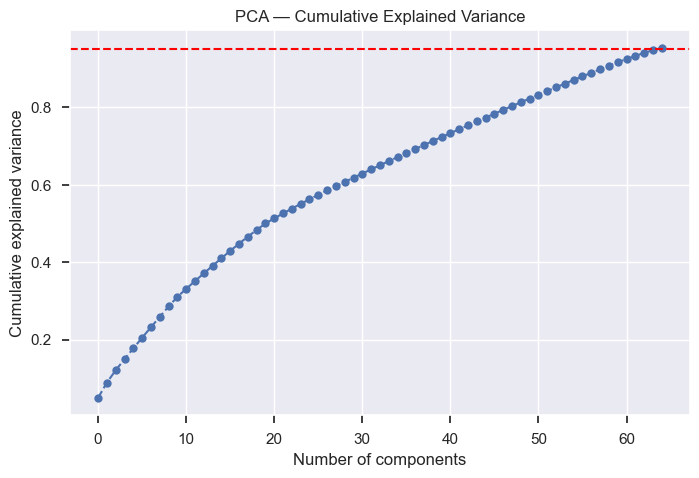

In [591]:
plt.figure(figsize=(8,5))
plt.plot(
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
    linestyle="--"
)
plt.axhline(0.95, color="red", linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA — Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [592]:
lr_pca = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

lr_pca.fit(X_train_pca, y_train)
lr_pca_auc, lr_pca_proba = evaluate_model_auc(
    lr_pca, X_test_pca, y_test, "Logistic Regression (PCA)"
)


Logistic Regression (PCA)
ROC-AUC: 0.7393

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.79      2212
           1       0.23      0.69      0.34       296

    accuracy                           0.69      2508
   macro avg       0.58      0.69      0.57      2508
weighted avg       0.86      0.69      0.74      2508



In [593]:
knn_pca = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance"
)

knn_pca.fit(X_train_pca, y_train)
knn_pca_auc, knn_pca_proba = evaluate_model_auc(
    knn_pca, X_test_pca, y_test, "KNN (PCA)"
)


KNN (PCA)
ROC-AUC: 0.6279

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2212
           1       0.24      0.07      0.11       296

    accuracy                           0.86      2508
   macro avg       0.56      0.52      0.52      2508
weighted avg       0.81      0.86      0.83      2508



In [594]:
nb_pca = GaussianNB()

nb_pca.fit(X_train_pca, y_train)
nb_pca_auc, nb_pca_proba = evaluate_model_auc(
    nb_pca, X_test_pca, y_test, "Naive Bayes (PCA)"
)


Naive Bayes (PCA)
ROC-AUC: 0.6268

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2212
           1       0.20      0.25      0.22       296

    accuracy                           0.80      2508
   macro avg       0.55      0.56      0.55      2508
weighted avg       0.81      0.80      0.81      2508



In [595]:
svm_pca = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    class_weight="balanced",
    random_state=42
)

svm_pca.fit(X_train_pca, y_train)
svm_pca_auc, svm_pca_proba = evaluate_model_auc(
    svm_pca, X_test_pca, y_test, "SVM (PCA)"
)


SVM (PCA)
ROC-AUC: 0.7201

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      2212
           1       0.21      0.60      0.31       296

    accuracy                           0.68      2508
   macro avg       0.57      0.65      0.55      2508
weighted avg       0.84      0.68      0.74      2508



Although PCA is not theoretically optimal for tree based models, we include Random Forest and XGBoost with PCA as a robustness check

In [596]:
xgb_pca = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight = (len(y_train[y_train==0]) / len(y_train[y_train==1])),
    learning_rate=0.05,
    max_depth=6,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_pca.fit(X_train_pca, y_train)

xgb_pca_auc, xgb_pca_proba = evaluate_model_auc(
    xgb_pca,
    X_test_pca,
    y_test,
    "XGBoost (PCA)"
)


XGBoost (PCA)
ROC-AUC: 0.6965

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2212
           1       0.26      0.28      0.27       296

    accuracy                           0.82      2508
   macro avg       0.58      0.59      0.58      2508
weighted avg       0.83      0.82      0.82      2508



In [597]:
rf_pca = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_pca.fit(X_train_pca, y_train)

rf_pca_auc, rf_pca_proba = evaluate_model_auc(
    rf_pca,
    X_test_pca,
    y_test,
    "Random Forest (PCA)"
)


Random Forest (PCA)
ROC-AUC: 0.6845

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2212
           1       0.30      0.05      0.09       296

    accuracy                           0.87      2508
   macro avg       0.59      0.52      0.51      2508
weighted avg       0.82      0.87      0.83      2508



In [598]:
comparison = pd.DataFrame({
    "No PCA": {
        "Logistic Regression": lr_auc,
        "KNN": knn_auc,
        "Naive Bayes": nb_auc,
        "SVM": svm_auc,
        "Random Forest": rf_auc,
        "XGBoost": xgb_auc
    },
    "With PCA": {
        "Logistic Regression": lr_pca_auc,
        "KNN": knn_pca_auc,
        "Naive Bayes": nb_pca_auc,
        "SVM": svm_pca_auc,
        "Random Forest": rf_pca_auc,
        "XGBoost": xgb_pca_auc
    }
})

comparison

,No PCA,With PCA
Logistic Regression,0.787915,0.739339
KNN,0.638931,0.627948
Naive Bayes,0.650402,0.626769
SVM,0.752380,0.720085
Random Forest,0.819225,0.684546
XGBoost,0.816726,0.696543


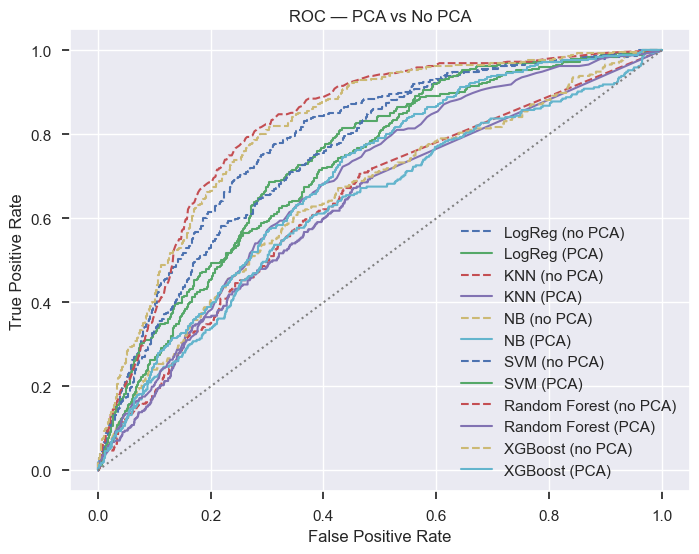

In [599]:
plt.figure(figsize=(8,6))

models_pca_roc = {
    "LogReg": (lr_proba, lr_pca_proba),
    "KNN": (knn_proba, knn_pca_proba),
    "NB": (nb_proba, nb_pca_proba),
    "SVM": (svm_proba, svm_pca_proba),
    "Random Forest": (rf_proba, rf_pca_proba),
    "XGBoost": (xgb_proba, xgb_pca_proba)
}

for name, (proba_np, proba_pca) in models_pca_roc.items():
    fpr, tpr, _ = roc_curve(y_test, proba_np)
    plt.plot(fpr, tpr, linestyle="--", label=f"{name} (no PCA)")

    fpr, tpr, _ = roc_curve(y_test, proba_pca)
    plt.plot(fpr, tpr, label=f"{name} (PCA)")

plt.plot([0,1], [0,1], linestyle=":", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — PCA vs No PCA")
plt.legend()
plt.grid(True)
plt.show()

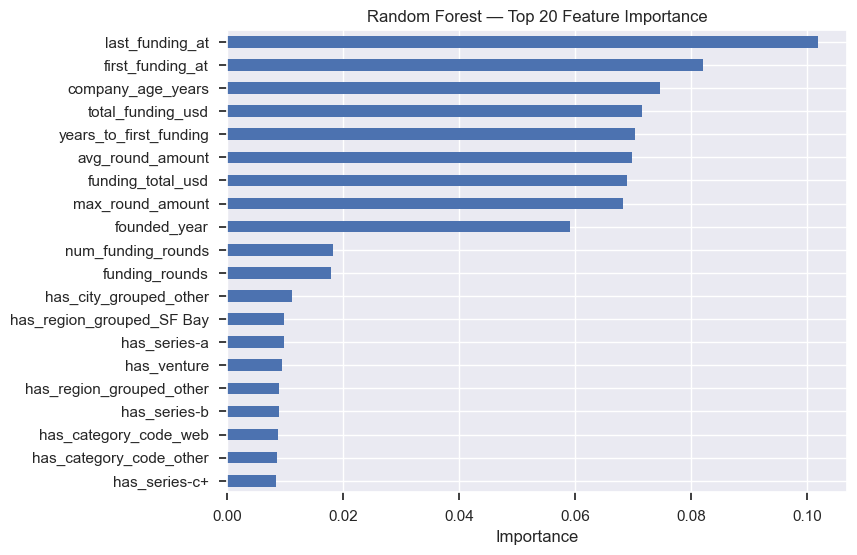

In [600]:
rf_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

rf_importance.head(20)

plt.figure(figsize=(8,6))
rf_importance.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest — Top 20 Feature Importance")
plt.xlabel("Importance")
plt.show()

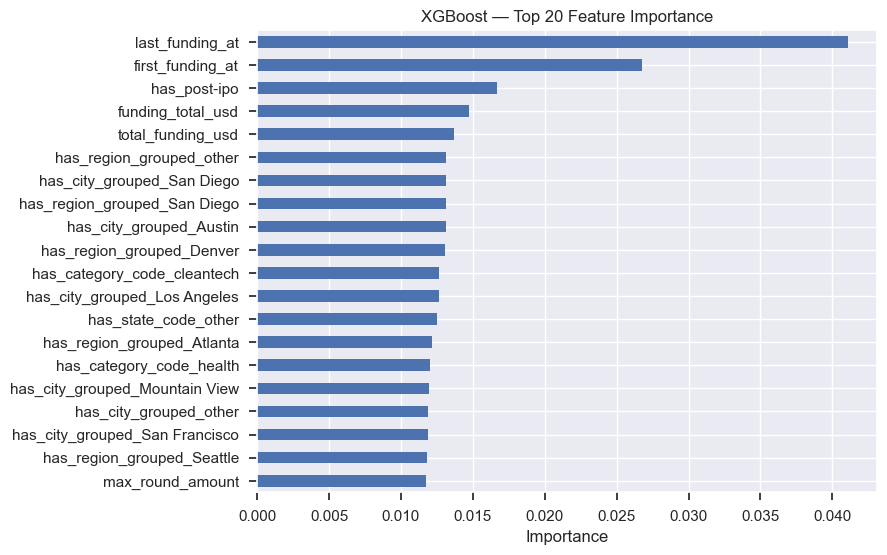

In [601]:
xgb_importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

xgb_importance.head(20)

plt.figure(figsize=(8,6))
xgb_importance.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("XGBoost — Top 20 Feature Importance")
plt.xlabel("Importance")
plt.show()